In [1]:
from warnings import filterwarnings

filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import datetime as dt 

import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
plt.rcdefaults()

sns.set(rc={'figure.figsize': tuple(plt.rcParams['figure.figsize'])})
sns.set(style="whitegrid", font_scale=1.75)

plt.rcParams['figure.figsize'] = [20.0, 5.0]
plt.rcParams['figure.dpi'] = 200
sns.set_palette(sns.color_palette('muted'))

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=75)

%config InlineBackend.figure_format = 'retina'

In [4]:
import os 

c = 0
for filename in os.listdir('./input'):
    c += 1
    print(str(c).zfill(2), f'/{filename}')

01 /artificialNoAnomaly
02 /artificialWithAnomaly
03 /README.md
04 /realAdExchange
05 /realAWSCloudwatch
06 /realKnownCause
07 /realTraffic
08 /realTweets


In [5]:
plt.rcParams['figure.figsize'] = [20.0, 5.0]

<AxesSubplot:>

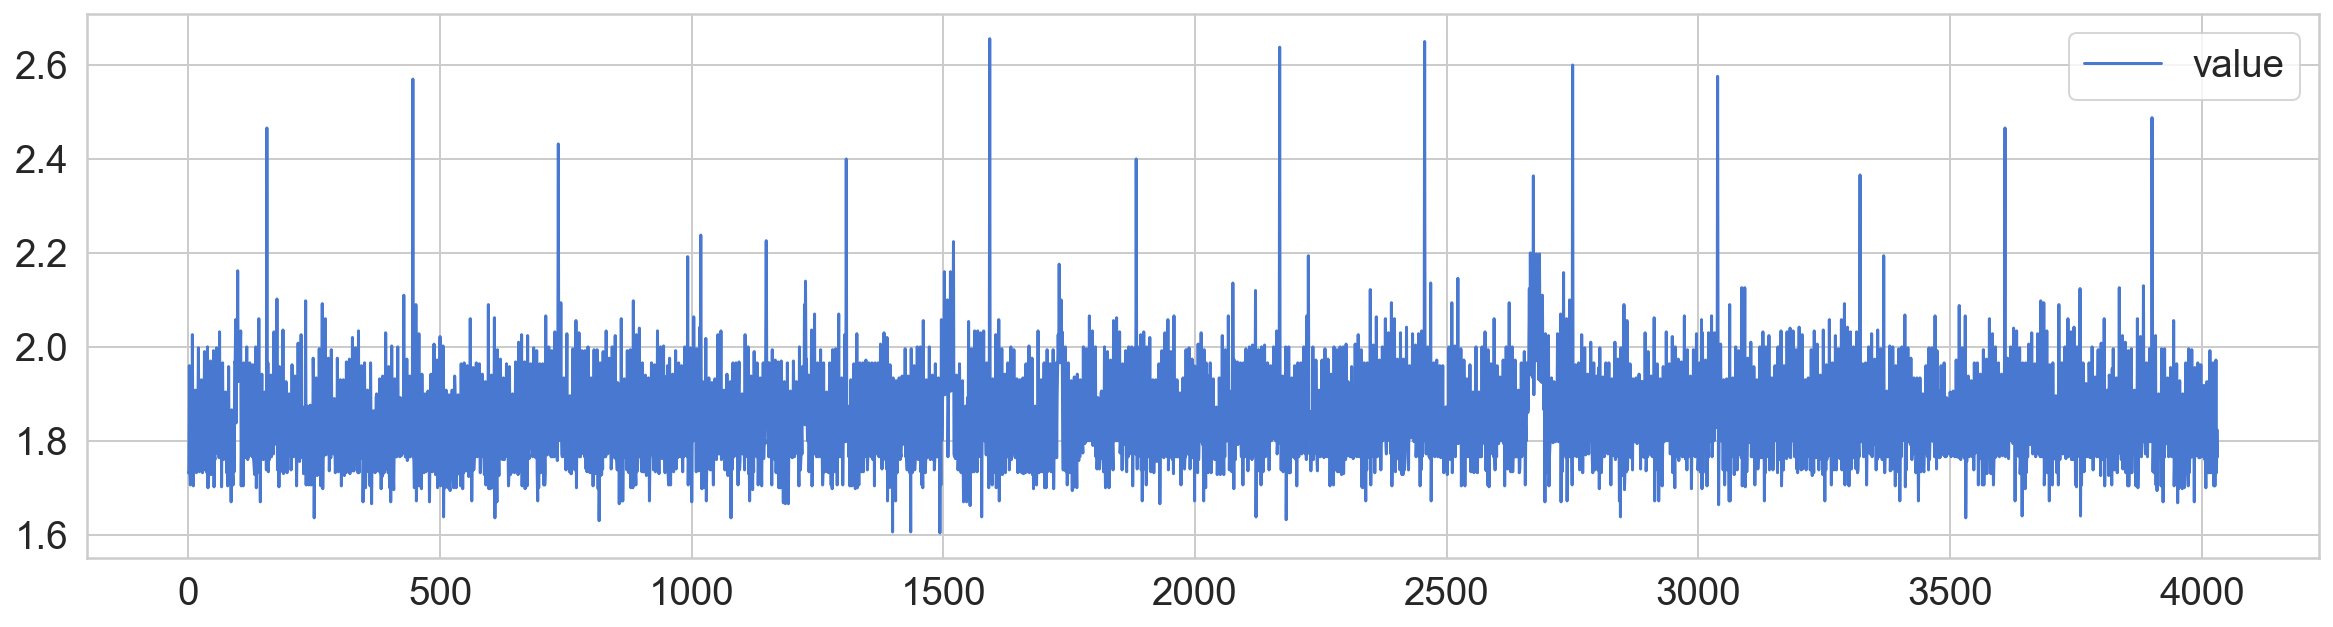

In [6]:
cpu = pd.read_csv('./input/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv')
cpu.plot()